In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import box
from scipy import ndimage
from datetime import datetime

In [2]:
ds = xr.open_dataset("temp/era5_t2min_scaled_anomalies.nc")
data_array = ds.sel(time='1985-02-07')['anomaly_scaled']

## Latitude weights

In [166]:
weights = np.cos(np.deg2rad(ds.latitude))

weights.name = "weights"
brod_weights = weights.broadcast_like(data_array)

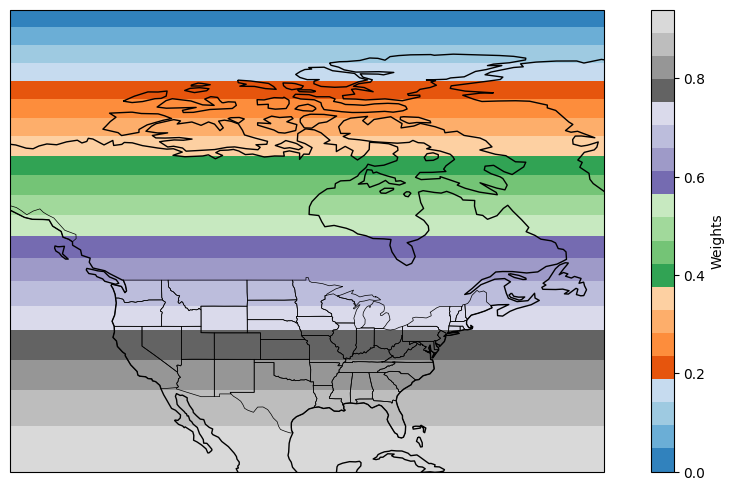

In [167]:
plt.figure(figsize=(12, 6))
axes = plt.axes(projection=ccrs.PlateCarree())#ccrs.NorthPolarStereo(central_longitude=-100))
main_plot = brod_weights.plot(transform=ccrs.PlateCarree(),cmap="tab20c",vmin=0,add_colorbar=False)
cb = plt.colorbar(main_plot)
cb.set_label("Weights")
axes.coastlines()
axes.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
axes.set_extent((-140, -50, 20, 90),ccrs.PlateCarree())
plt.show()

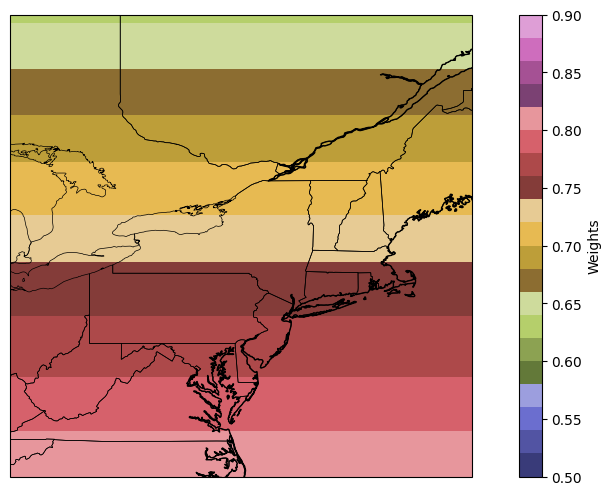

In [168]:
lonW =-83.1
lonE = -68.1
latS = 35.4
latN = 50.4


plt.figure(figsize=(12, 6))
axes = plt.axes(projection=ccrs.PlateCarree())#ccrs.NorthPolarStereo(central_longitude=-100))
main_plot = brod_weights.plot(transform=ccrs.PlateCarree(),cmap="tab20b",vmin=0.5,vmax=0.9,add_colorbar=False)
cb = plt.colorbar(main_plot)
cb.set_label("Weights")
axes.coastlines()
axes.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
axes.set_extent((lonW, lonE, latS, latN),ccrs.PlateCarree())
plt.show()


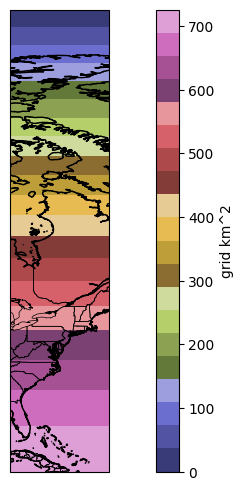

In [175]:
#Area of each grid cell
R = 6371 #km^2
weights = (R**2)*np.deg2rad(0.25)*np.deg2rad(0.25)*np.cos(np.deg2rad(ds.latitude))
weights.name = "weights"
brod_weights = weights.broadcast_like(data_array)

lonW =-83.1
lonE = -68.1
latS = 20
latN = 90


plt.figure(figsize=(12, 6))
axes = plt.axes(projection=ccrs.PlateCarree())#ccrs.NorthPolarStereo(central_longitude=-100))
main_plot = brod_weights.plot(transform=ccrs.PlateCarree(),cmap="tab20b",vmin=0,add_colorbar=False)
cb = plt.colorbar(main_plot)
cb.set_label("grid km^2")
axes.coastlines()
axes.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
axes.set_extent((lonW, lonE, latS, latN),ccrs.PlateCarree())
plt.show()

## Gaussian weights

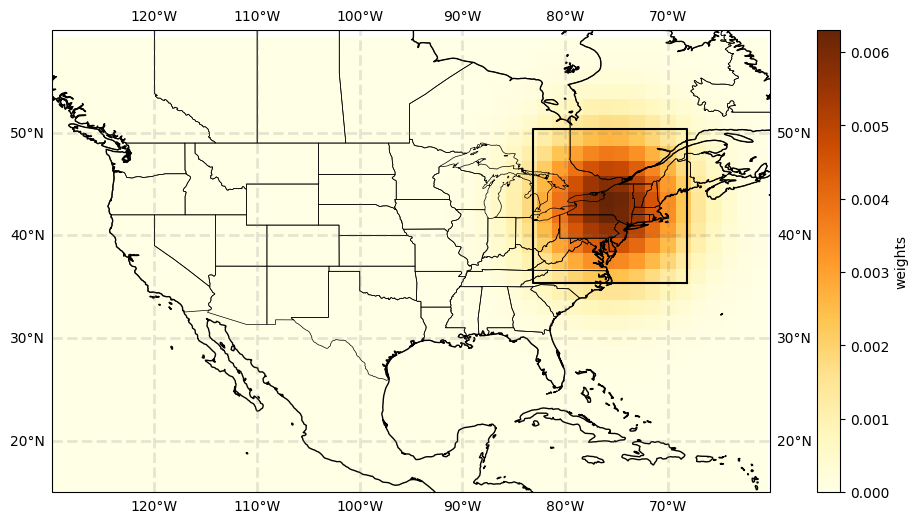

In [8]:
center_lon = -75.6
center_lat = 42.9
lonmin = -130
lonmax = -60
latmin = 15
latmax = 60

lons = np.arange(lonmin,lonmax,1.5)
lats = np.arange(latmin,latmax,1.5)

X, Y = np.mgrid[latmin:latmax:1.5,lonmin:lonmax:1.5]

xo=center_lon
yo=center_lat
b=5
G = 1/(2*np.pi*b**2) * np.exp(-((X-yo)**2 + (Y-xo)**2)/(2*b**2))

ds_gaussian_weights = xr.Dataset(

    data_vars={"weights": (["lat", "lon"], G)},

    coords={"lat": lats, "lon": lons}

)

#Bounds of the gaussian
Glonmin=xo - 1.5*b
Glonmax=xo + 1.5*b
Glatmin=yo - 1.5*b
Glatmax=yo + 1.5*b

rectangle = box(Glonmin, Glatmin, Glonmax, Glatmax)
x_rec,y_rec = rectangle.exterior.xy

plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True,linewidth=2,color='gray',alpha=0.2,linestyle='--')
g=ds_gaussian_weights["weights"].plot(cmap='YlOrBr',transform=ccrs.PlateCarree(),vmin=0)
ax.set_extent((-130,-60,15,60),ccrs.PlateCarree())
ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
ax.coastlines()
plt.plot(x_rec,y_rec,color='black')
plt.show()

## Drawing circles, using matplotlib

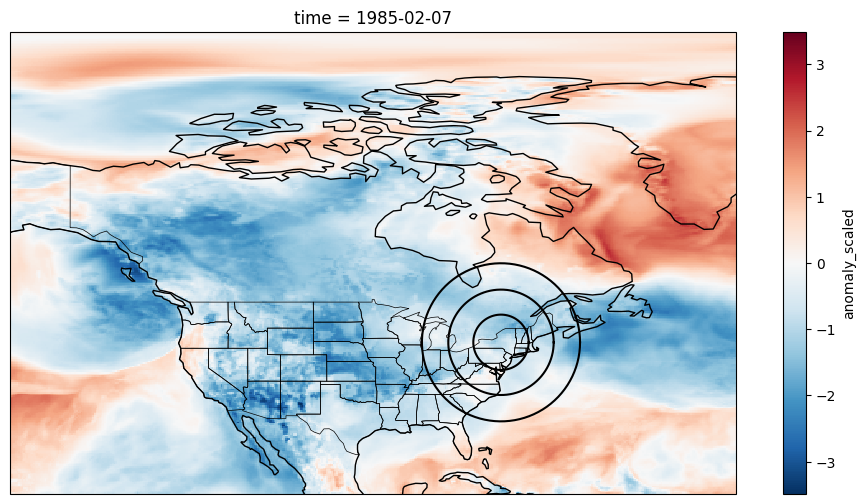

In [66]:
def draw_circle(ax, x, y, r, m, label):
    th = np.linspace(0, 2 * np.pi, 100)
    nx = x + r * np.cos(th)
    ny = y + r * np.sin(th)
    ax.plot(nx, ny, m, label=label)
center_lon = -75.6
center_lat = 42.9
map_proj = ccrs.NorthPolarStereo(central_longitude=-100)
map_proj = ccrs.PlateCarree()
plt.figure(figsize=(12, 6))
axes = plt.axes(projection=map_proj)
data_array.plot(transform=ccrs.PlateCarree())
draw_circle(axes, center_lon, center_lat, m='k-', r=4.2, label='grid 0 radius')
draw_circle(axes, center_lon, center_lat, m='k-', r=8, label='grid 0 radius')
draw_circle(axes, center_lon, center_lat, m='k-', r=12, label='grid 0 radius')
axes.coastlines()
axes.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
plt.show()

## Drawing circles, using cartopy

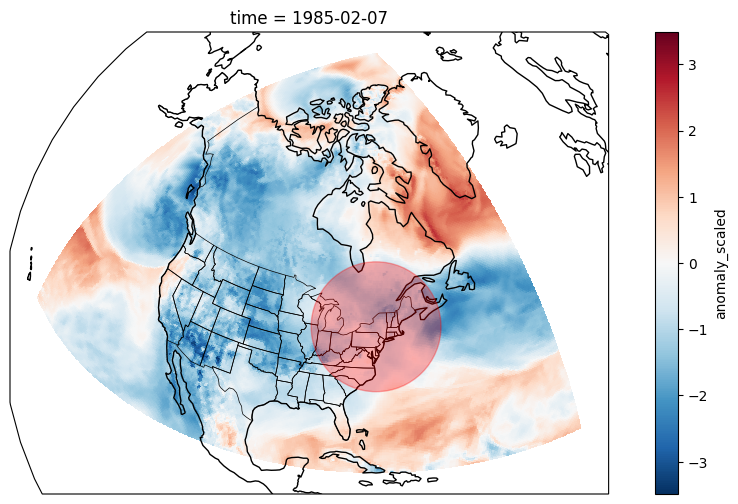

In [7]:
lat = 42.9
lon = -75.6
r = 10
map_proj = ccrs.Orthographic(central_longitude=lon, central_latitude=lat)
def compute_radius(ortho, radius_degrees,):
    phi1 = lat + radius_degrees if lat <= 0 else lat - radius_degrees
    _, y1 = ortho.transform_point(lon, phi1, ccrs.PlateCarree())
    return abs(y1)

# Compute the required radius in projection native coordinates:
r_ortho = compute_radius(map_proj, r)


plt.figure(figsize=(12, 6))
axes = plt.axes(projection=map_proj)
data_array.plot(transform=ccrs.PlateCarree())
axes.coastlines()
axes.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
axes.add_patch(mpatches.Circle(xy=[lon, lat], radius=r_ortho, color='red', alpha=0.3, transform=map_proj, zorder=30))
plt.show()


## extra: transforming projections

In [128]:
#Two projections
lat = 42.9
lon = -75.6
map_proj_to = ccrs.Orthographic(central_longitude=lon, central_latitude=lat)
map_proj_from = ccrs.PlateCarree()

In [129]:
map_proj_from

<Projected CRS: +proj=eqc +ellps=WGS84 +a=6378137.0 +lon_0=0.0 +to ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (unknown)
- N[north]: Northing (unknown)
- h[up]: Ellipsoidal height (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Equidistant Cylindrical
Datum: Unknown based on WGS 84 ellipsoid
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [130]:
map_proj_to

<Projected CRS: +proj=ortho +a=6378137.0 +lon_0=-75.59999999999999 ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Orthographic
Datum: unknown
- Ellipsoid: unknown
- Prime Meridian: Greenwich

In [170]:
#Original rectangle
rectangle = box(-83.1, 35.4, -68.1, 80)
x_rec, y_rec = rectangle.exterior.xy

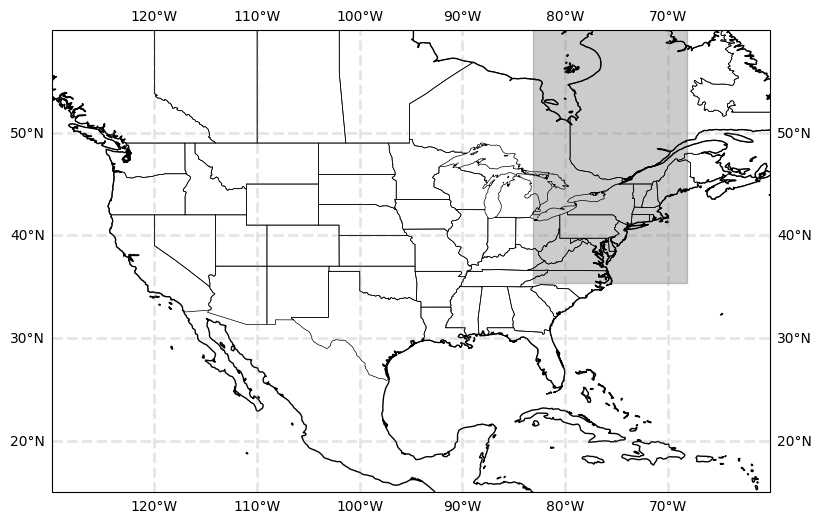

In [171]:
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=map_proj_from)
gl = ax.gridlines(draw_labels=True,linewidth=2,color='gray',alpha=0.2,linestyle='--')
ax.set_extent((-130,-60,15,60),ccrs.PlateCarree())
ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
ax.coastlines()
ax.fill(x_rec,y_rec,color='black',alpha=0.2)
plt.show()

In [172]:
lons,lats =  rectangle.exterior.xy
lons = np.array(lons.tolist())
lats = np.array(lats.tolist())


rect_new_coords = map_proj_to.transform_points(map_proj_from, lons, lats)
x_coords = []
y_coords = []
for rect in rect_new_coords:
    x_coords.append(rect[0])
    y_coords.append(rect[1])
x_coords = np.array(x_coords[:-1])
y_coords = np.array(y_coords[:-1])

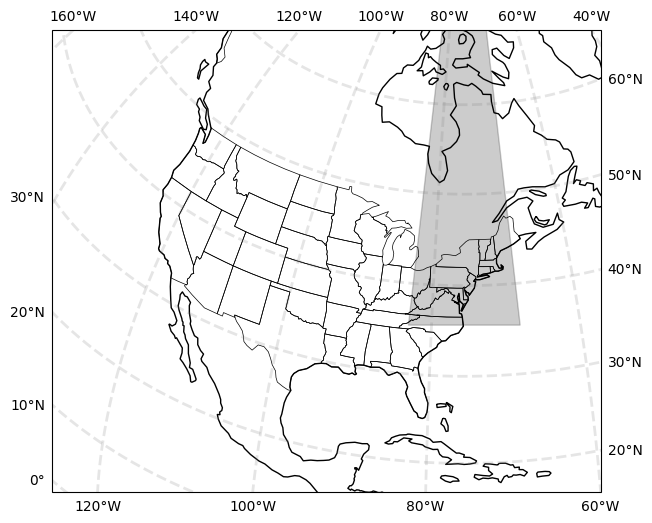

In [173]:
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=map_proj_to)
gl = ax.gridlines(draw_labels=True,linewidth=2,color='gray',alpha=0.2,linestyle='--')
ax.set_extent((-130,-60,15,60),ccrs.PlateCarree())
ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
ax.coastlines()
ax.fill(x_coords,y_coords,color='black',alpha=0.2)
plt.show()